<a href="https://colab.research.google.com/github/klsharma22/TensorflowCertifcationCourse/blob/main/Milestone%20Projects/09_milestone_project_2_Skim_Lit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating is avaliable here: [PubMed 200k RCT](https://arxiv.org/abs/1710.06071)

Reading through the paper above, we see that the model architecture that they use to achieve their best results is availbale here: [Neural Networks for Joint Sentence Classification](https://arxiv.org/abs/1612.05251)

## Get data

Since we are replicating the model from the above paper, let's use their data.

[Dataset](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
# Check what files are in the PubMed20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [9]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign
# data_dir = '/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Milestone Projects/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [10]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to get one with it.

In [11]:
# Create a function to read the lines of the document
def get_lines(filename):
    '''
    Reads filename and returns the lines of text as a list.

    Args:
        filename (str): Path of filename

    Returns:
        A list of string with one string per line from the target filename
    '''

    with open(filename, 'r') as f:
        return f.readlines()

In [12]:
# Let's read in the training lines
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

Let's think about how we want our data to look

Representation of the data:

```
[{'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'xyz',
    'total_lines': 11}]
```

In [13]:
def preprocess_text_with_line_numbers(filename):
    '''
    Returns a list of dictionary of abstract line data.

    Takes in filename, reads it contents and sorts through each line, extracting things like the target label, the text of the sentence, number of snetences and what sentence number line is.
    '''
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines: # if the line is the id number
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace(): # if it is the new line
            abstract_line_split = abstract_lines.splitlines()

            for line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)

        else: # if it is the text
            abstract_lines += line

    return abstract_samples

In [14]:
train_samples = preprocess_text_with_line_numbers(filenames[2])
val_samples = preprocess_text_with_line_numbers(filenames[1])
test_samples = preprocess_text_with_line_numbers(filenames[0])

len(train_samples), len(val_samples), len(test_samples)

(30212, 30135, 180040)

In [15]:
# Check the first abstract
train_samples[:14]

[{'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 9},
 {'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 9},
 {'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'line_number': 2,
  'total_lines': 9},
 {'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'line_number': 3,
  'total_lines': 9},
 {'targe

Now that we have our data in the form of dictionary, let's create a dataframe

In [16]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


In [17]:
# Distribution of labels
train_df['target'].value_counts()

METHODS        9964
RESULTS        9841
CONCLUSIONS    4582
BACKGROUND     3449
OBJECTIVE      2376
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

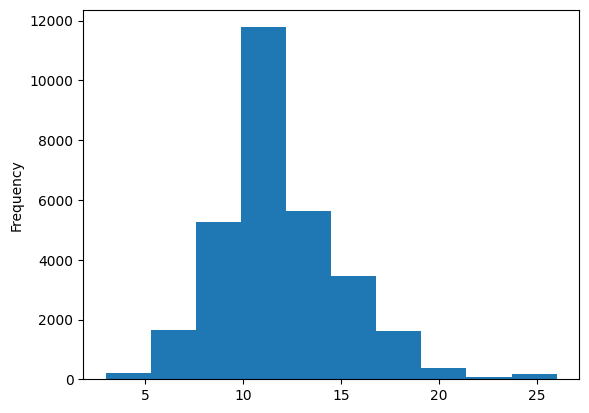

In [18]:
# Let's check length of different lines
train_df['total_lines'].plot.hist()

### Get a lists of sentences

In [19]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(30212, 30135, 180040)

## Make numeric labels

In [20]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse= False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

len(train_labels_one_hot), len(val_labels_one_hot), len(test_labels_one_hot)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(30212, 30135, 180040)

## Label encode labels

In [21]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [22]:
# get class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments

### Model 0: Getting a baseling

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X= train_sentences,
            y= train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluate baseline model on validation dataset
model_0.score(X= val_sentences,
              y= val_labels_encoded)

0.6755931640949062

In [25]:
# Make prediction using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

#### Download helper function script for evaluation

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [28]:
from helper_functions import calculate_results

In [29]:
# Calculate baseline results
baseline_results = calculate_results(y_true= val_labels_encoded,
                                     y_pred= baseline_preds)
baseline_results

{'accuracy': 67.55931640949062,
 'precision': 0.6707354792180861,
 'recall': 0.6755931640949062,
 'f1': 0.6337858496380697}

In [30]:
import tensorflow as tf

## Preparing our data for deep sequence models

Before we start building deep model, we've got tocreate vectorization and embedding layers

In [31]:
import numpy as np
from tensorflow.keras import layers

In [32]:
# how long is ech sentences on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sent_lens)
avg_sentence_len

26.42244803389382

(array([2.083e+03, 8.066e+03, 7.916e+03, 5.940e+03, 2.761e+03, 1.675e+03,
        7.520e+02, 4.430e+02, 2.290e+02, 1.330e+02, 8.100e+01, 3.900e+01,
        3.100e+01, 2.200e+01, 1.400e+01, 8.000e+00, 5.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  1.        ,   9.56666667,  18.13333333,  26.7       ,
         35.26666667,  43.83333333,  52.4       ,  60.96666667,
         69.53333333,  78.1       ,  86.66666667,  95.23333333,
        103.8       , 112.36666667, 120.93333333, 129.5       ,
        138.06666667, 146.63333333, 155.2       , 163.76666667,
        172.33333333, 180.9       , 189.46666667, 198.03333333,
        206.6       , 215.16666667, 223.73333333, 232.3       ,
        240.86666667, 249.43333333, 258.        ]),
 <BarContainer object of 30 artists>)

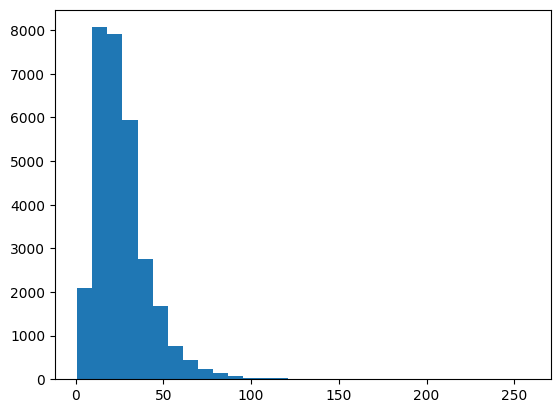

In [33]:
# What is the distribution of the sentences
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins= 30)

In [34]:
# How longof a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [35]:
# maximum sequence length
max(sent_lens)

258

### Create text vectorizzer layer

We want to make a layer which converts text data into vectors

In [36]:
# Creating text vectorizer
max_vocab = 68000
text_vectorizer = layers.TextVectorization(max_tokens= max_vocab,
                                           output_sequence_length= output_seq_len)

In [37]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [38]:
# Test out text vectorizer on random sentences

import random
target_senteces = random.choice(train_sentences)
print(f"Text: {target_senteces}")
print(f"Length of Text: {len(target_senteces.split())}")
print(f"Vectorized: {text_vectorizer(target_senteces)}")

Text: our objective was to evaluate the accuracy of a novel , simplified , four-step ( @s ) technique .
Length of Text: 19
Vectorized: [  252   370    10     6   168     2  1193     4     8   679  4040 22108
   136   392     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [39]:
# How many words in our training vocab
rct_20k_vocab = text_vectorizer.get_vocabulary()

print(f"Number of words in vocab: {len(rct_20k_vocab)}")
print(f"Most common words: {rct_20k_vocab[:5]}")
print(f"Least common words: {rct_20k_vocab[-5:]}")

Number of words in vocab: 25008
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aas', 'aaraai', 'aale', 'aai', 'aado']


In [40]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 25008}

### Create an embedding layer

In [41]:
embedding = layers.Embedding(input_dim= len(rct_20k_vocab),
                             output_dim= 128,
                             mask_zero= True, # use masking to handle variable sequence length
                             name= 'token_embedding'
                             )

In [42]:
random_sentence = random.choice(train_sentences)
print(f"Text: {random_sentence}")
print(f"Embed: {embedding(text_vectorizer([random_sentence])).shape}")

Text: worldwide , haloperidol is the first choice for pharmacological treatment of delirious patients .
Embed: (1, 55, 128)


## Creating dataset

We're going to setup our data to run as fast as possible with tf.data API

In [43]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [44]:
# Take the tensor_slice dataset and turn them into prefetch dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: CNN 1D

In [45]:
inputs = layers.Input(shape= (1, ), dtype= 'string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, activation= 'relu', padding='same', name= 'cnn_1d_layer')(x)
x = layers.GlobalAveragePooling1D(name= 'global_avg_pool_layer')(x)
outputs = layers.Dense(num_classes, activation= 'softmax', name= 'output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           3201024   
 )                                                               
                                                                 
 cnn_1d_layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_avg_pool_layer (Glo  (None, 64)                0         
 balAveragePooling1D)                                            
                                                             

In [46]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              epochs= 5,
                              validation_data= val_dataset,
                              validation_steps= int(0.1 * len(val_dataset)))

Epoch 1/5
94/94 [==============================] - 4s 17ms/step - loss: 1.4452 - accuracy: 0.3983 - val_loss: 1.2896 - val_accuracy: 0.5093
Epoch 2/5
94/94 [==============================] - 1s 8ms/step - loss: 1.0487 - accuracy: 0.6047 - val_loss: 0.8781 - val_accuracy: 0.6373
Epoch 3/5
94/94 [==============================] - 1s 8ms/step - loss: 0.8125 - accuracy: 0.6868 - val_loss: 0.7600 - val_accuracy: 0.6898
Epoch 4/5
94/94 [==============================] - 1s 8ms/step - loss: 0.7412 - accuracy: 0.7184 - val_loss: 0.7112 - val_accuracy: 0.7251
Epoch 5/5
94/94 [==============================] - 1s 7ms/step - loss: 0.7154 - accuracy: 0.7291 - val_loss: 0.6904 - val_accuracy: 0.7291


In [47]:
model_1.evaluate(val_dataset)

942/942 [==============================] - 6s 6ms/step - loss: 0.7066 - accuracy: 0.7283


[0.7066354751586914, 0.7283225655555725]

In [52]:
model_1_pred = tf.argmax(model_1.predict(val_dataset), axis= 1).numpy()
model_1_pred

942/942 [==============================] - 4s 5ms/step


array([0, 2, 2, ..., 4, 4, 4])

In [55]:
# Calculate results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_pred)
model_1_results

{'accuracy': 72.83225485316078,
 'precision': 0.7229501745272373,
 'recall': 0.7283225485316077,
 'f1': 0.7095907956777016}

In [56]:
baseline_results

{'accuracy': 67.55931640949062,
 'precision': 0.6707354792180861,
 'recall': 0.6755931640949062,
 'f1': 0.6337858496380697}

In [58]:
import tensorflow_hub as hub

In [66]:
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        trainable= False,
                                        name= 'USE_layer')

### Model 2: Transfer Learning

In [83]:
inputs = layers.Input(shape= [], dtype= 'string', name= 'input_layer')
x = sentence_encoder_layer(inputs)
x = layers.Dense(128, activation= 'relu')(x)
outputs = layers.Dense(num_classes, activation= 'softmax', name= 'output_layer')(x)

model_2 = tf.keras.Model(inputs= inputs, outputs= outputs, name= 'model_2_USE')

model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

In [84]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [85]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              epochs= 5,
                              validation_data= val_dataset,
                              validation_steps= int(0.1 * len(val_dataset)))

Epoch 1/5
94/94 [==============================] - 3s 24ms/step - loss: 1.2666 - accuracy: 0.5053 - val_loss: 1.0127 - val_accuracy: 0.6230
Epoch 2/5
94/94 [==============================] - 2s 24ms/step - loss: 0.9180 - accuracy: 0.6529 - val_loss: 0.8769 - val_accuracy: 0.6636
Epoch 3/5
94/94 [==============================] - 2s 19ms/step - loss: 0.8329 - accuracy: 0.6822 - val_loss: 0.8413 - val_accuracy: 0.6769
Epoch 4/5
94/94 [==============================] - 3s 30ms/step - loss: 0.8067 - accuracy: 0.6865 - val_loss: 0.8220 - val_accuracy: 0.6848
Epoch 5/5
94/94 [==============================] - 2s 19ms/step - loss: 0.8098 - accuracy: 0.6892 - val_loss: 0.8028 - val_accuracy: 0.6858


In [86]:

model_2_pred = tf.argmax(model_2.predict(val_dataset), axis= 1)
model_2_pred

942/942 [==============================] - 9s 9ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 2])>

In [87]:
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_pred)
model_2_results

{'accuracy': 68.664343786295,
 'precision': 0.6821004465805215,
 'recall': 0.68664343786295,
 'f1': 0.6800709476058484}

In [88]:
baseline_results, model_1_results

({'accuracy': 67.55931640949062,
  'precision': 0.6707354792180861,
  'recall': 0.6755931640949062,
  'f1': 0.6337858496380697},
 {'accuracy': 72.83225485316078,
  'precision': 0.7229501745272373,
  'recall': 0.7283225485316077,
  'f1': 0.7095907956777016})